# Building Stochastic Gradient Descent with Regularization

In [1]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda, Inc.| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.13.1
Pandas Version: 0.20.3


In [30]:
import numpy as np
import pandas as pd

class sgd_regressor:
    
    def __init__(self, n_iter=100, alpha=0.01, verbose=False, return_steps=False, fit_intercept=True, 
                 dynamic=False, loss='ols', epsilon=0.1, regularize='L2', lamb=1e-6, l1_perc = 0.5):
        """
        Stochastic Gradient Descent Algorithm, with OLS cost function.
        ---
        KWargs:
        
        n_iter: number of epochs to run in while fitting to the data. Total number of steps
        will be n_iter*X.shape[0]. 
        alpha: The learning rate. Moderates the step size during the gradient descent algorithm.
        verbose: Whether to print out coefficient information during the epochs  
        return_steps: If True, fit returns a list of the coefficients at each update step for diagnostics   
        fit_intercept: If True, an extra coefficient is added with no associated feature to act as the
                       base prediction if all X are 0.                   
        dynamic: If true, an annealing scedule is used to scale the learning rate.    
        regularize: Choose what type, if any, of regularization to apply. Options are "L2" (Ridge),
                    "L1" (Lasso), and "EN" (Elastic Net: L1 + L2). All other inputs will not apply
                    regularization    
        lamb: Stands for lambda. Sets the strength of the regularization. Large lambda causes large
              regression. If regularization is off, this does not apply to anything.        
        l1_perc: If using elastic net, this variable sets what portion of the penalty is L1 vs L2. 
                 If regularize='EN' and l1_perc = 1, equivalent to regularize='L1'. If 
                 regularize='EN' and l1_perc = 0, equivalent to regulzarize='L2'.
        """
        self.coef_ = None
        self.trained = False
        self.n_iter = n_iter
        self.alpha_ = alpha
        self.verbosity = verbose
        self._return_steps = return_steps
        self._fit_intercept = fit_intercept
        self._next_alpha_shift = 0.1 # Only used if dynamic=True
        self._dynamic = dynamic
        self._regularize = regularize
        self._lamb = lamb
        self._l1_perc = l1_perc
        if self._l1_perc > 1. or self._l1_perc < 0.:
            raise ValueError("l1_perc must be between 0 and 1")
        
    def update(self, x, error):
        """
        Calculating the change of the coeficients for SGD. This is the derivative of the cost 
        function. B_i = B_i - alpha * dJ/dB_i. If fit_intercept=True, a slightly different 
        value is used to update the intercept coefficient, since the associated feature is "1."
        ---
        Inputs:
        
        data_point: A single row of the feature matrix. Since this is Stochastic, batches are not allowed.
        
        error: The residual for the current data point, given the current coefficients. Prediction - True
        for the current datapoint and coefficients.
        """
        if self._regularize == 'L2':
            step = self.alpha_*error*x + 2*self._lamb*self.coef_[1:]
        elif self._regularize == 'L1':
            step = self.alpha_*error*x + self._lamb*np.sign(self.coef_[1:])
        elif self._regularize == "EN":
            step = self.alpha_*error*x + 2*(1 - self._l1_perc)*self._lamb*self.coef_[1:] + self._l1_perc*self._lamb*np.sign(self.coef_[1:])
        else:
            step = self.alpha_*error*x
            
        # We don't regularize the intercept term. This term is adjusting for the "shift" in our
        # target data - and we don't want to shrink it, or we'll introduce bias.
        if self._fit_intercept:  
            self.coef_[1:] -= step
            self.coef_[0] -= self.alpha_ * error
        else:
            self.coef_ -= step
        
    def shuffle_data(self, X, y):
        """
        Given X and y, shuffle them together to get a new_X and new_y that maintain feature-target
        correlations. 
        ---
        Inputs:
        
        X: A numpy array of any shape
        y: A numpy array of any shape
        
        Both X and y must have the same first dimension length.
        
        Returns:
        X,y: two numpy arrays
        """
        assert len(X) == len(y)
        permute = np.random.permutation(len(y))
        return X[permute], y[permute]
        
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
        
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
    
    def dynamic_learning_rate_check(self, epoch):
        """
        If dynamic=True, shrink the learning rate by a factor of 2 after every 10% of
        the total number of epochs. This should cause a more direct path to the global 
        minimum after the initial large steps.
        ---
        Inputs: epoch (int,float), the current iteration number. 
        """
        percent_of_epochs = float(epoch)/float(self.n_iter)
        if percent_of_epochs > self._next_alpha_shift:
            self._next_alpha_shift += 0.1
            self.alpha_ = self.alpha_/2.
            
    def fit(self, X, y):
        """
        Actually trains the model. Given feature-target combinations, gradient descent is performed
        using the optimization stepping given in the 'update' function. At present, all epochs are 
        completed, as no tolerance is set. The learning rate is currently fixed.
        ---
        Inputs: 
            X (array, dataframe, series), The features to regress on using SGD
            y (array, series), Must be a 1D set of targets.
        Outputs:
            steps (optional): If return_steps=True, a list of the evolution of the coefficients is returned
        """
        X = self.convert_to_array(X)
        y = self.convert_to_array(y)
        self._stdy = np.std(y)
        self.coef_ = self.init_coef(X)
        if self._return_steps:
            steps = []
            steps.append(np.copy(self.coef_))
        for epoch in range(self.n_iter):
            shuf_X, shuf_y = self.shuffle_data(X,y)
            if self.verbosity:
                print("Epoch ", epoch, ", Coeff: ", self.coef_)
            for data, true in zip(shuf_X,shuf_y):
                pred = self.predict(data, is_array=True)
                error = pred - true
                self.update(data, error)
                if self._return_steps:
                    steps.append(np.copy(self.coef_))
            if self._dynamic:
                self.dynamic_learning_rate_check(epoch)
        if self._return_steps:
            return steps
            
    def init_coef(self, X):
        """
        Returns the initial starting values for the coefficients. At present, these are randomly
        set. If fit_intercept = True, an extra coefficient is generated. 
        ---
        Input: X, Feature matrix. Needed to decide how many coefficients to generate.
        """
        if self._fit_intercept:
            return np.random.rand(X.shape[1]+1)
        return np.random.rand(X.shape[1])

    def predict(self, X, is_array=False):  
        """
        Returns a prediction for a new data set, using the model coefficients.
        ---
        Input: 
            X (dataframe, array): The new feature set. Must be the same number of columns
            as the initial training features. 
        Output:
            prediction (array): The dot product of the input data and the coeficients.
        """
        if not is_array:
            X = self.convert_to_array(X)
        if not self.coef_.all():
            raise ValueError("Coefficients not defined, must fit() before predict().")
        if self._fit_intercept:
            return np.dot(X,self.coef_[1:]) + self.coef_[0]
        return np.dot(X,self.coef_)
    
    def score(self, X, y):
        """
        Uses the predict method to measure the (negative)
        mean squared error of the model.
        ---
        In: X (list or array), feature matrix; y (list or array) labels
        Out: negative mean squared error (float)
        """
        pred = self.predict(X)
        return -1.* np.mean((np.array(pred)-np.array(y))**2)

# Let's Gen some data to see how it behaves

In [2]:
def gen_data(rows = 200, gen_coefs = [2,4], gen_inter = 0):
    X = np.random.rand(rows,len(gen_coefs))
    y = np.sum(np.tile(np.array(gen_coefs),(X.shape[0],1))*X,axis=1)
    y = y + np.random.normal(0,0.5, size=X.shape[0])
    y = y + gen_inter
    return X, y

actual_coefs = [10,8,9,10,11]
X, y = gen_data(gen_coefs=actual_coefs[1:], gen_inter=actual_coefs[0])

It will work with Pandas or Numpy arrays. Let's play with Pandas for now.

In [3]:
import pandas as pd
cols = []
for i in range(X.shape[1]):
    cols.append('X'+str(i))
data = pd.DataFrame(X, columns=cols)
data['y'] = y
data.head()

,X0,X1,X2,X3,y
0,0.808817,0.027014,0.263306,0.465295,24.284067
1,0.061235,0.074427,0.937476,0.487208,25.693154
2,0.668164,0.814405,0.114800,0.423463,28.029647
3,0.103332,0.373444,0.392359,0.041720,18.970851
4,0.381980,0.024030,0.068742,0.896605,23.553096


In [4]:
sgd = sgd_regressor(n_iter=500, alpha=1e-3, verbose=False, return_steps=True, dynamic=False, 
                    regularize='EN', lamb=1e-6)

In [5]:
steps = sgd.fit(data.iloc[:,:-1],data.iloc[:,-1])

In [6]:
sgd.coef_

array([ 10.4628966 ,   7.77683361,   8.90004987,   9.69196435,  10.72393654])

In [7]:
test_X, test_y = gen_data(rows=200, gen_coefs=actual_coefs[1:], gen_inter=actual_coefs[0])
pred_y = sgd.predict(test_X)
test_err = pred_y - test_y

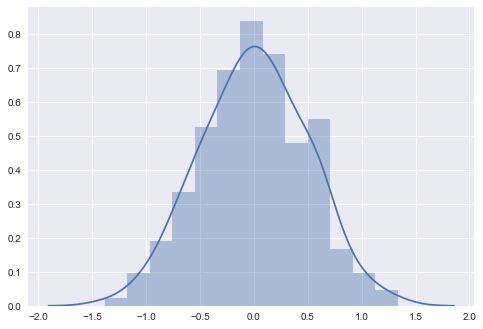

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

sns.distplot(test_err);

In [9]:
from scipy.stats import normaltest
print(normaltest(test_err))

NormaltestResult(statistic=0.28203593075160338, pvalue=0.86847370910095711)


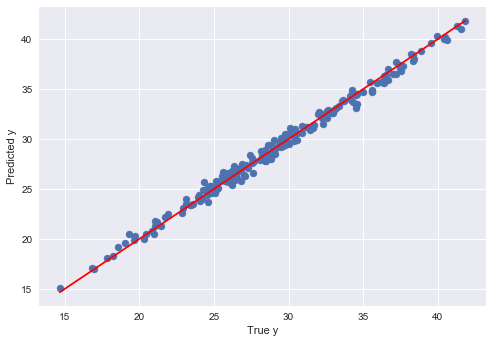

In [10]:
plt.scatter(test_y, pred_y, s=50)
temp = np.linspace(min(test_y),max(test_y),100)
plt.plot(temp,temp,'r-')
plt.xlabel("True y")
plt.ylabel("Predicted y");

## Let's look at how the optimization looks in the Coefficient Space!

In [11]:
def plot_beta_space(steps, components = (0,1), last_300=False, zoom=False):
    plt.figure(figsize=(20,16))
    try:
        B0 = np.array(steps).T[components[0]]
        B1 = np.array(steps).T[components[1]]
    except:
        print("Couldn't find those components, defaulting to (0,1)")
        B0 = np.array(steps).T[0]
        B1 = np.array(steps).T[1]
    if last_300:
        steps_to_show=-300
        skip = 2
        plt.scatter(B0[steps_to_show::skip],B1[steps_to_show::skip],c=plt.cm.rainbow(np.linspace(0,1,len(B0[steps_to_show::skip]))));
        plt.scatter(steps[steps_to_show][0],steps[steps_to_show][1],c='r',marker='x', s=400,label='Start')
        plt.scatter(steps[-1][0],steps[-1][1],c='k',marker='x', s=400,label='End')
        plt.title("Movement in the Coefficient Space, Last "+str(-steps_to_show)+" steps!",fontsize=32);
    else: 
        plt.scatter(B0[::25],B1[::25],c=plt.cm.rainbow(np.linspace(0,1,len(B0[::25]))));
        plt.scatter(steps[0][0],steps[0][1],c='r',marker='x', s=400,label='Start')
        plt.scatter(steps[-1][0],steps[-1][1],c='k',marker='x', s=400,label='End')
        plt.title("Movement in the Coefficient Space",fontsize=32);
    plt.legend(fontsize=32, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');
    plt.xlabel("B"+str(components[0]),fontsize=26)
    plt.ylabel("B"+str(components[1]),fontsize=26);
    if zoom:
        plt.ylim(min(B1[steps_to_show::skip]), max(B1[steps_to_show::skip]))
        plt.xlim(min(B0[steps_to_show::skip]), max(B0[steps_to_show::skip]));

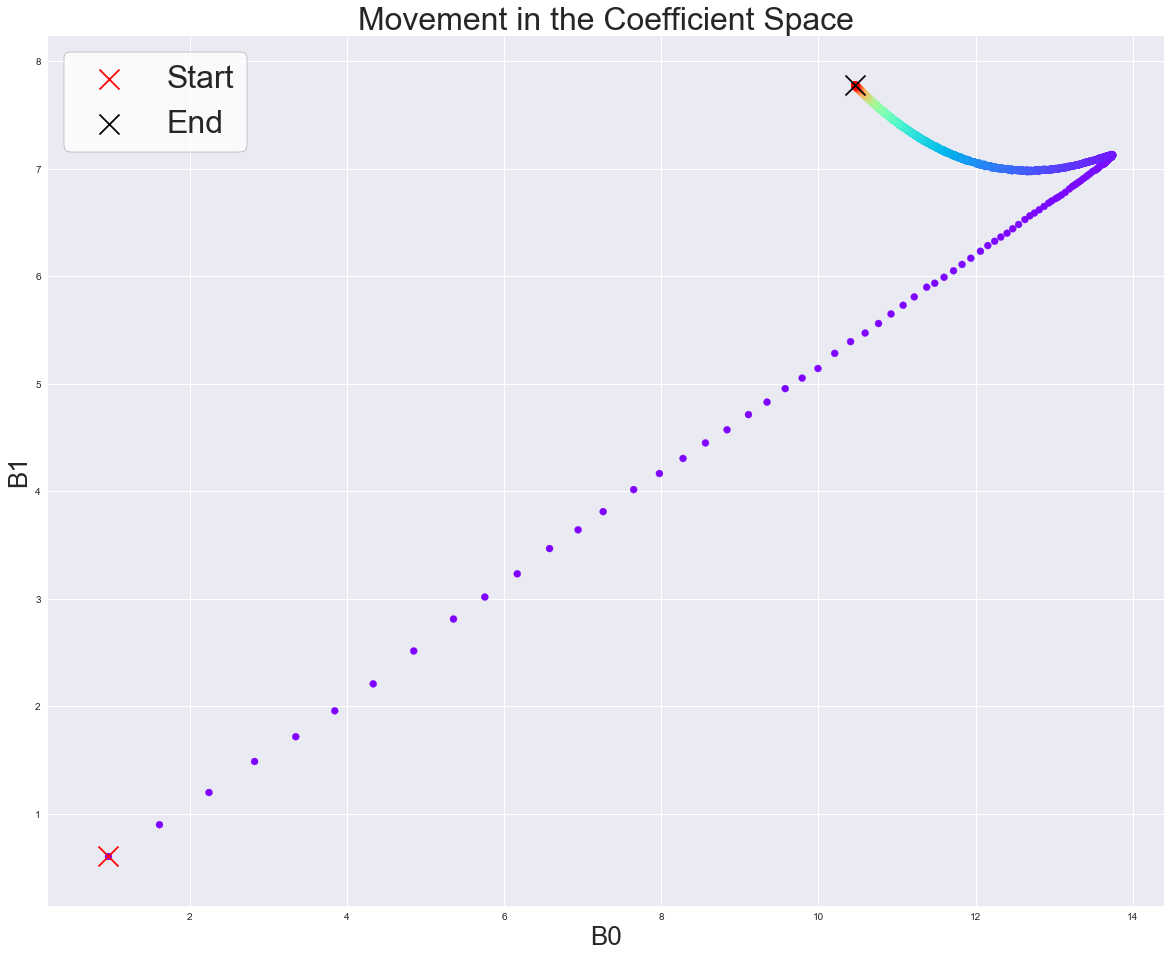

In [12]:
plot_beta_space(steps)

** Now let's look at the last 300 steps. NOTE THE SCALE CHANGE! **

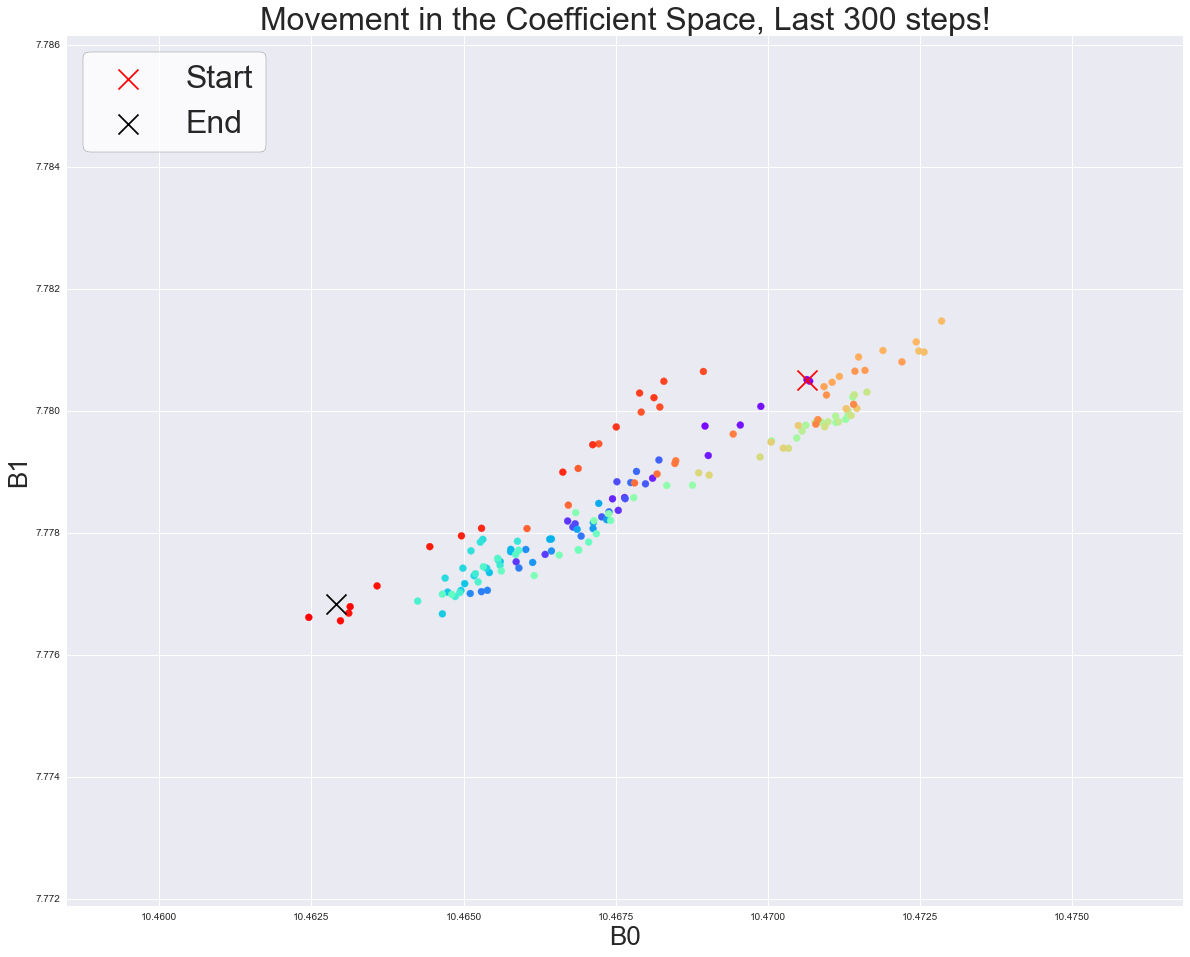

In [13]:
plot_beta_space(steps, last_300=True)

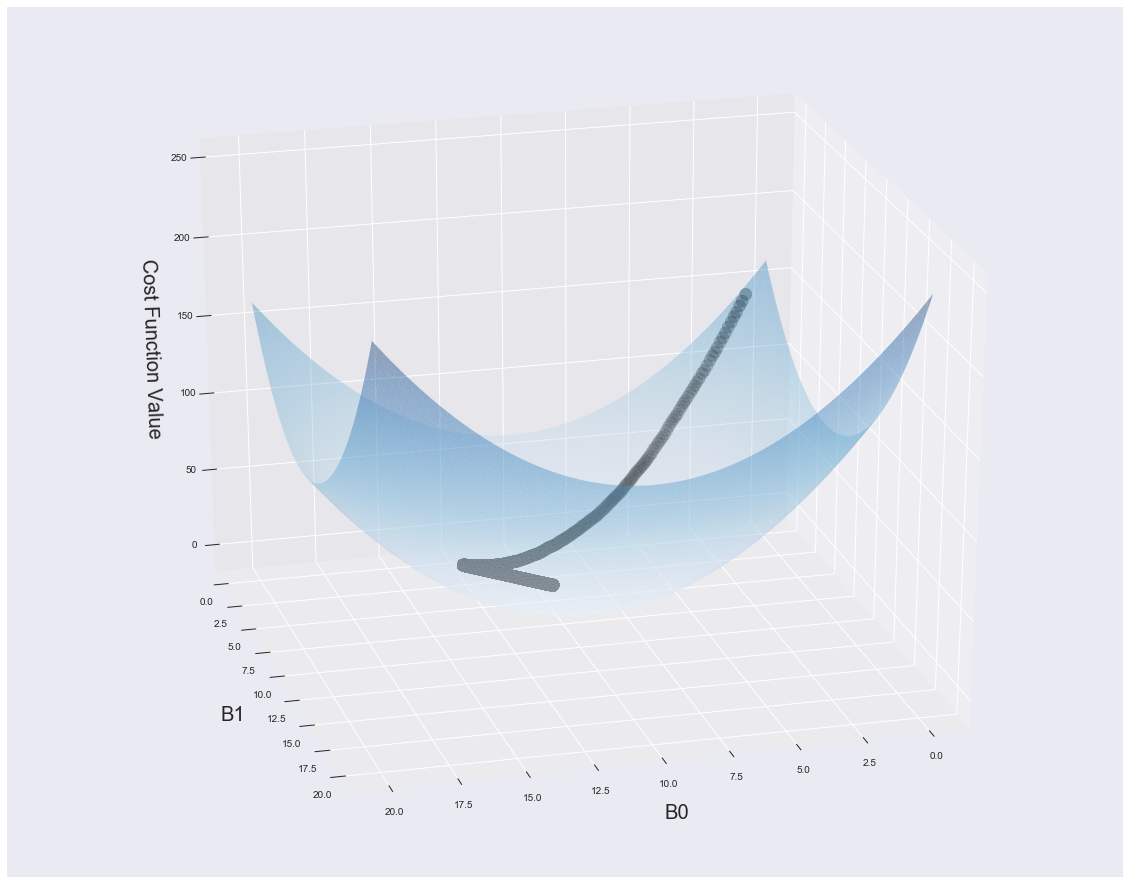

In [14]:
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')

def plot_beta_space3D(steps, components = (0,1)):
    def cost_function(x,y):
        return (x-actual_coefs[components[0]])**2 + (y-actual_coefs[components[1]])**2
    
    plot_vals_x = []
    plot_vals_y = []
    plot_vals_z = []
    for b1 in np.linspace(0,20,100):
        for b2 in np.linspace(0,20,100):
            cost = cost_function(b1,b2)
            plot_vals_x.append(b1)
            plot_vals_y.append(b2)
            plot_vals_z.append(cost)
    
    try:
        B0 = np.array(steps).T[components[0]]
        B1 = np.array(steps).T[components[1]]
    except:
        print("Couldn't find those components, defaulting to (0,1)")
        B0 = np.array(steps).T[0]
        B1 = np.array(steps).T[1]
    
    Z = cost_function(B0, B1)+10
    fig = plt.figure(figsize=(20,16))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(plot_vals_x,plot_vals_y,plot_vals_z, cmap=plt.cm.Blues, linewidth=0.2, alpha=0.4)
    ax.scatter(B0[::5],B1[::5],Z[::5],c='k',s=150);
    ax.set_xlabel("B0", fontsize=20, labelpad=20)
    ax.set_ylabel("B1", fontsize=20, labelpad=20)
    ax.set_zlabel("Cost Function Value", fontsize=20, labelpad=20);
    return ax

ax = plot_beta_space3D(steps)
ax.view_init(25, 75)

## Let's look at it with dynamic learning rate turned on

In [15]:
sgd2 = sgd_regressor(n_iter=500, alpha=1e-3, verbose=False, 
                     return_steps=True, dynamic=True, regularize='EN',lamb=1e-6)

In [16]:
steps2 = sgd2.fit(data.iloc[:,:-1],data.iloc[:,-1])
print(sgd2.coef_)

[ 12.49477035   6.3475187    7.47011751   7.94033877   8.77165857]


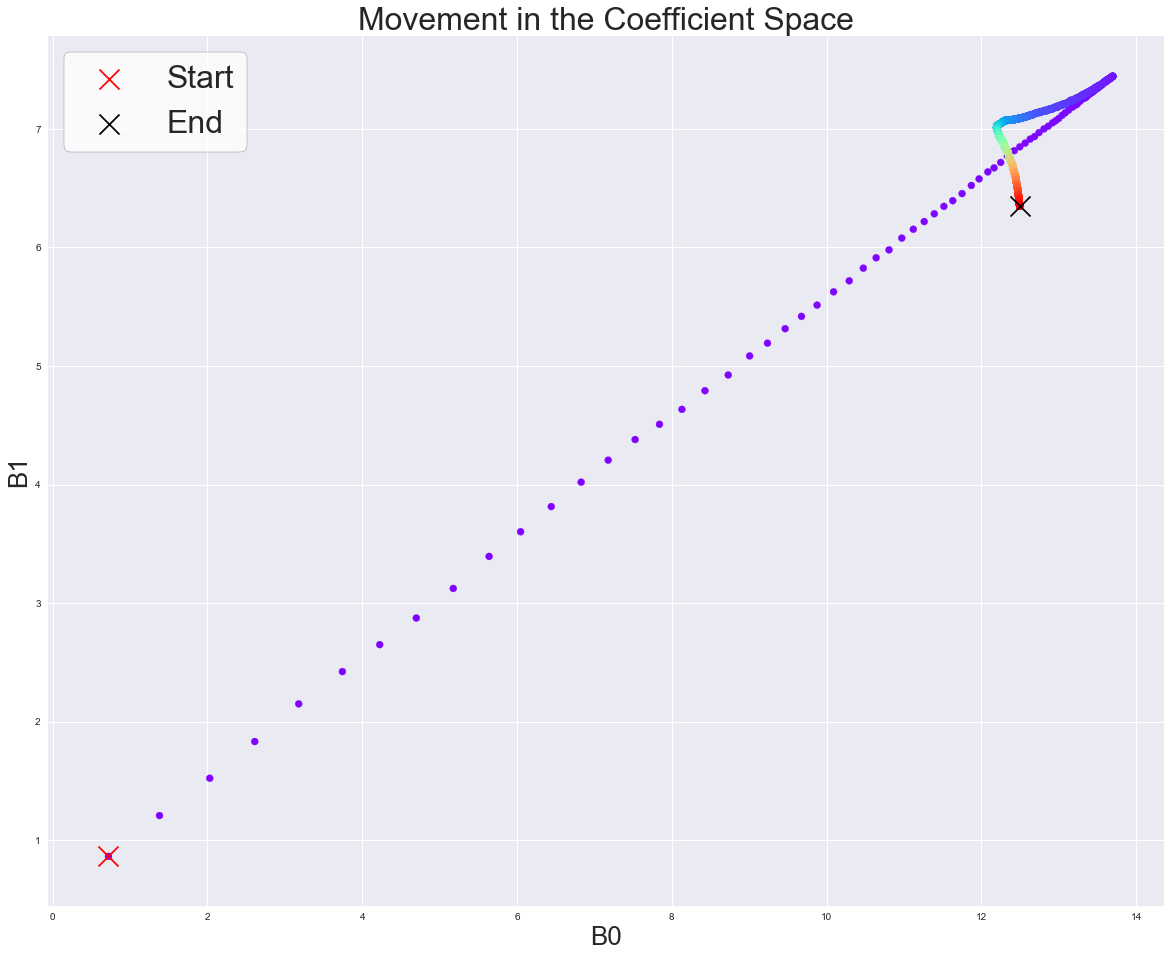

In [17]:
plot_beta_space(steps2)

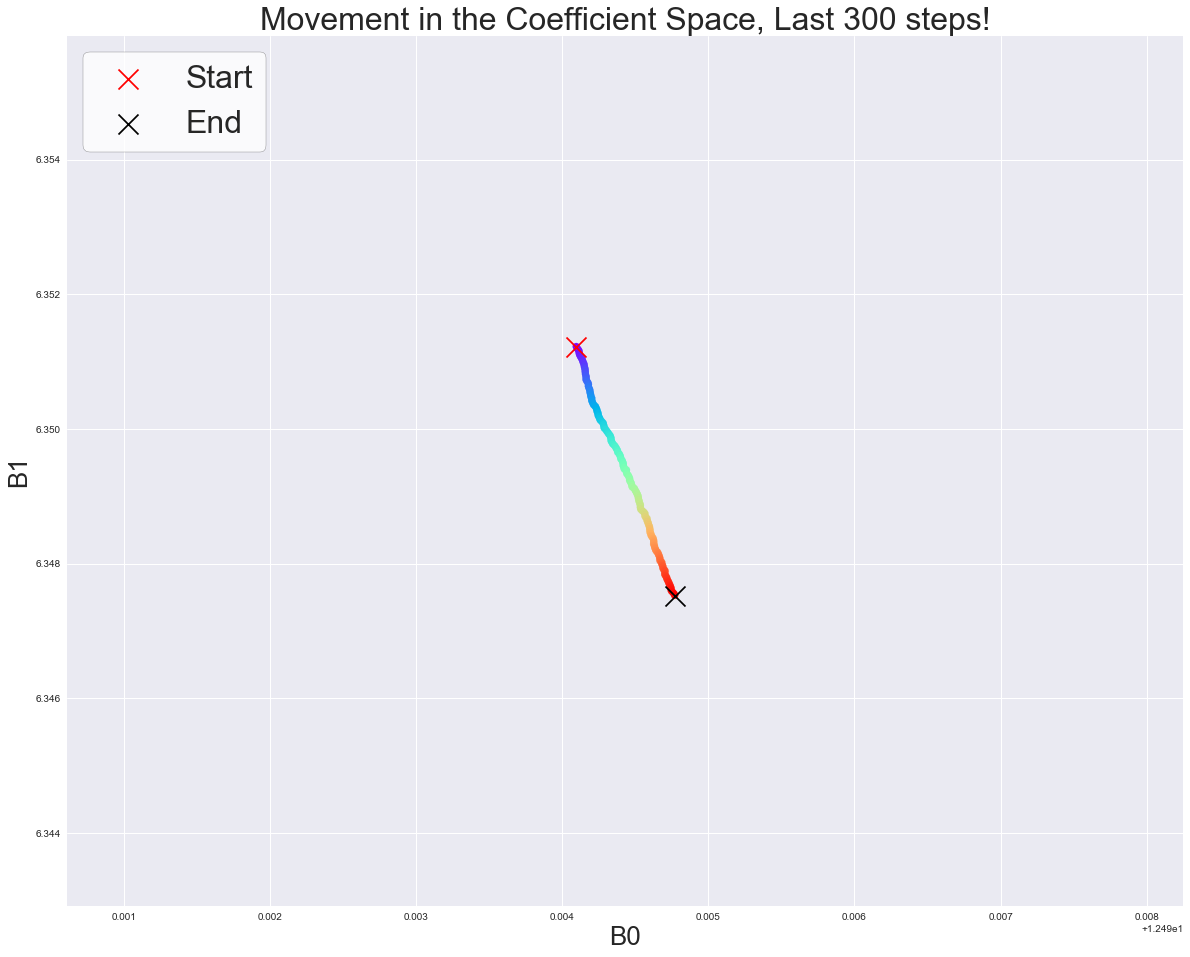

In [18]:
plot_beta_space(steps2, last_300=True)

Zoom in!

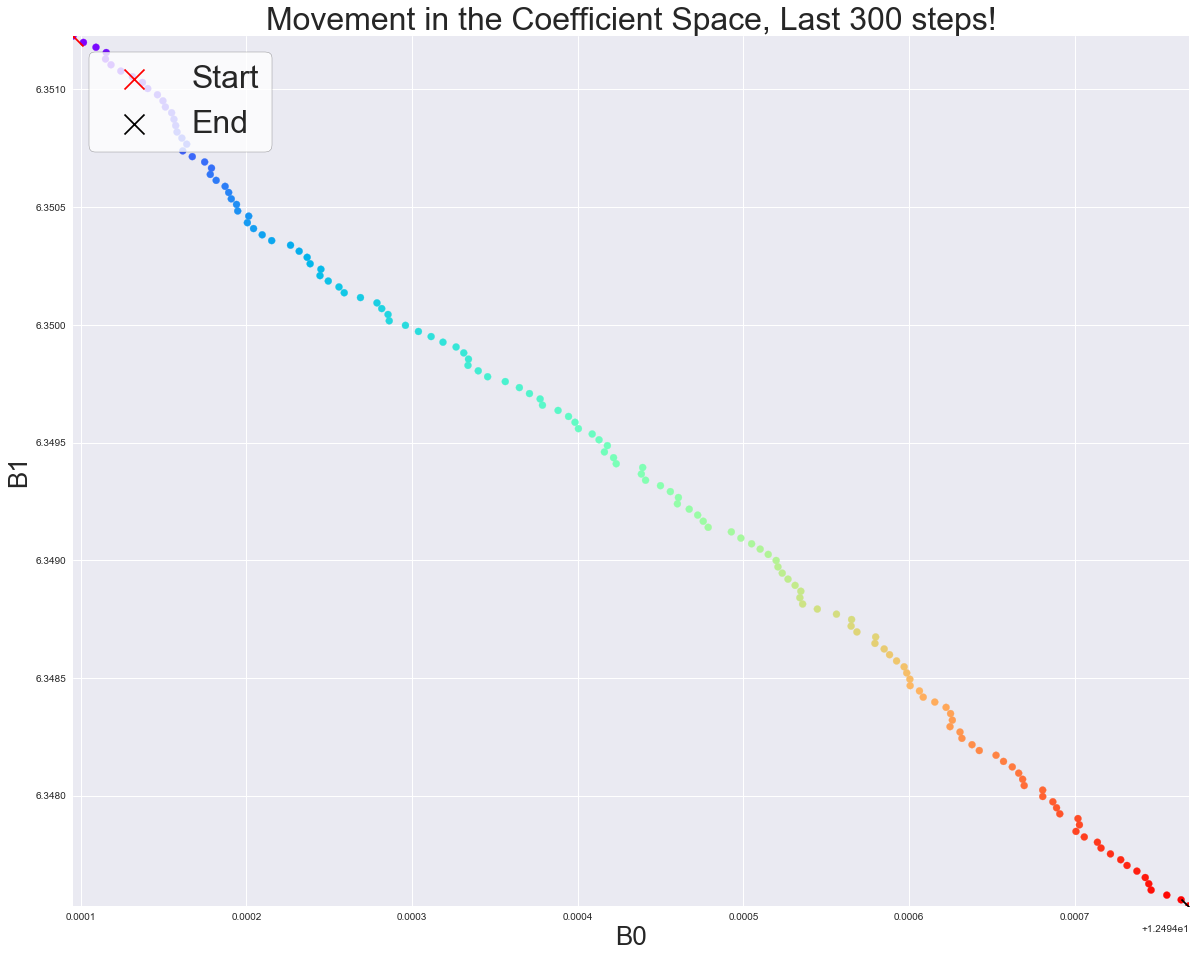

In [19]:
plot_beta_space(steps2, last_300=True, zoom=True)

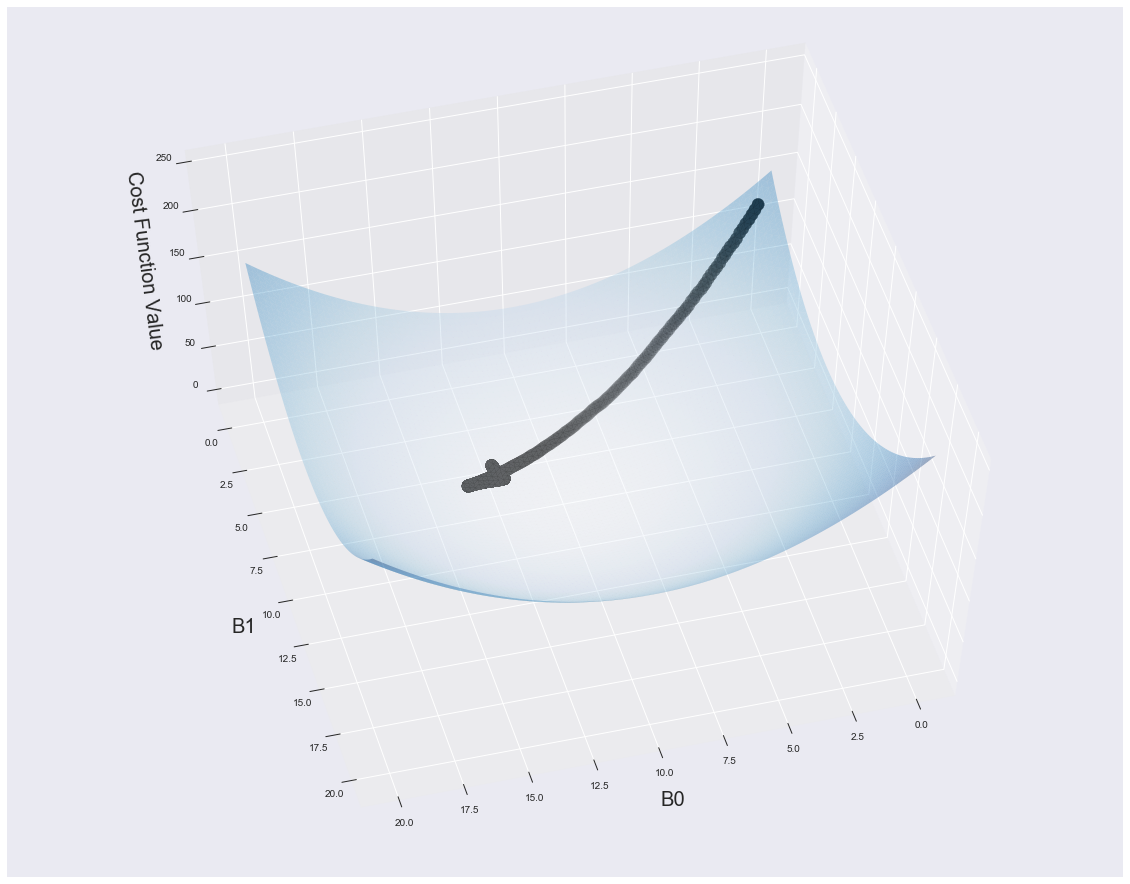

In [20]:
ax2 = plot_beta_space3D(steps2)
ax2.view_init(60, 75);

# Now let's test with some "real data"

In [21]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

In [22]:
X = pd.DataFrame(StandardScaler().fit_transform(load_boston().data))
y = pd.DataFrame(load_boston().target)

In [23]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02
mean,6.340997e-17,-6.343191e-16,-2.682911e-15,4.701992e-16,2.490322e-15,-1.145230e-14,-1.407855e-15,9.210902e-16,5.441409e-16,-8.868619e-16,-9.205636e-15,8.163101e-15,-3.370163e-16
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00
min,-4.177134e-01,-4.877224e-01,-1.557842e+00,-2.725986e-01,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-9.828429e-01,-1.313990e+00,-2.707379e+00,-3.907193e+00,-1.531127e+00
25%,-4.088961e-01,-4.877224e-01,-8.676906e-01,-2.725986e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-6.379618e-01,-7.675760e-01,-4.880391e-01,2.050715e-01,-7.994200e-01
50%,-3.885818e-01,-4.877224e-01,-2.110985e-01,-2.725986e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-5.230014e-01,-4.646726e-01,2.748590e-01,3.811865e-01,-1.812536e-01
75%,6.248255e-03,4.877224e-02,1.015999e+00,-2.725986e-01,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.661245e+00,1.530926e+00,8.065758e-01,4.336510e-01,6.030188e-01
max,9.941735e+00,3.804234e+00,2.422565e+00,3.668398e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.661245e+00,1.798194e+00,1.638828e+00,4.410519e-01,3.548771e+00


In [24]:
# Simplest form - fit intercept, no dynamic learning for comparison
sgd = sgd_regressor(n_iter=1000, fit_intercept=True, regularize='L2',lamb=1e-6)
sgd.fit(X.iloc[:100],y[:100])

In [25]:
sgd.coef_

array([ 15.69054405, -10.42861724,   0.0323316 ,  -1.32506288,
        -3.09572521,   1.3808069 ,   5.95983132,  -2.14347955,
        -0.09297356,  -0.29320311,  -1.272674  ,  -0.22108453,
         1.15846103,  -0.11689071])

### Let's compare our coefficients and results to SkLearn

In [26]:
from sklearn.linear_model import SGDRegressor

# To match our form, we use alpha=0 (no regularization), the same iterations, and a constant learning rate
sgd_sk = SGDRegressor(alpha=1e-6, penalty='L2', n_iter=1000, learning_rate='constant', )
sgd_sk.fit(X.iloc[:100],y[:100])

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=1e-06, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
       loss='squared_loss', max_iter=1000, n_iter=None, penalty='L2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [27]:
print(sgd_sk.intercept_,sgd_sk.coef_)

[ 15.00134643] [-11.68942725   0.03644803  -1.35004919  -4.08515579   1.44369818
   5.96016632  -2.13432628  -0.176492    -0.24822929  -1.24889376
  -0.11710234   1.13326027  -0.06972418]


In [28]:
new_X = X.iloc[-100:]
my_pred = sgd.predict(new_X)
sk_pred = sgd_sk.predict(new_X)

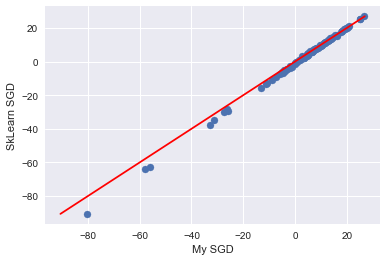

In [29]:
plt.scatter(my_pred,sk_pred)
plt.xlabel("My SGD")
plt.ylabel("SkLearn SGD");
line_val = np.linspace(min(sk_pred),max(sk_pred),10)
plt.plot(line_val,line_val,'r-');